In [1]:
import os
import tarfile
import pandas as pd
from tqdm.notebook import tqdm

In [2]:
os.chdir('yelp_academic')

In [3]:
restaurants = pd.read_csv('data/business_restaurant.csv')
ambience = pd.read_csv('data/business_ambience.csv')

In [4]:
r_photos = set(list(restaurants.photo_id))
a_photos = set(list(ambience.photo_id))

In [5]:
photos = r_photos | a_photos

In [6]:
len(photos), len(r_photos), len(a_photos)

(84222, 59556, 32928)

In [7]:
filenames = [os.path.join('photos', filename + '.jpg') for filename in photos]

In [8]:
tar = tarfile.open("all_photos.tar", "w")
for filename in tqdm(filenames):
    tar.add(filename)
tar.close()

  0%|          | 0/84222 [00:00<?, ?it/s]

In [9]:
filenames[0]

'photos/jvOJUwoAgSfrY1ZokUZX4g.jpg'

## TV test

In [50]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image, ImageDraw, ImageFont
import cv2

import numpy as np
import colorsys
import random

In [9]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [10]:
detection_model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(
    pretrained=True, progress=True, num_classes=91, pretrained_backbone=True, trainable_backbone_layers=None)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /home/ophelion/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

In [11]:
detection_model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [13]:
img = Image.open(filenames[0]) 
transform = transforms.Compose([transforms.ToTensor()])
img = transform(img)

In [23]:
def get_prediction(model, image, threshold):
    
    transform = transforms.Compose([transforms.ToTensor()])
    img = transform(image)
    
    preds = model([img])[0]
    
    keep_boxes = torchvision.ops.nms(preds['boxes'], preds['scores'], 0.5)
    
    classes = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(preds['labels'].numpy())]
    classes = [classes[idx] for idx in keep_boxes]
    boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(preds['boxes'].detach().numpy())]
    boxes = [boxes[idx] for idx in keep_boxes]
    scores = list(preds['scores'].detach().numpy())
    scores = [scores[idx] for idx in keep_boxes]
    masks = list(preds['masks'].detach().numpy())
    masks = [masks[idx] for idx in keep_boxes]
    
    valid_boxes = [scores.index(x) for x in scores if x>threshold]
    if not valid_boxes: return [()]
    p_thresh = valid_boxes[-1]
    pred_boxes = boxes[:p_thresh+1]
    pred_classes = classes[:p_thresh+1]
    pred_scores = scores[:p_thresh+1]
    pred_masks = masks[:p_thresh+1]
    
    return list(zip(pred_boxes, pred_classes, pred_scores, pred_masks))

In [38]:
preds = get_prediction(od_model, Image.open(filenames[1]), 0.5)

In [25]:
def draw_boxes(model, img_path, threshold=0.5):
    img = Image.open(img_path)
    draw = ImageDraw.Draw(img)
    predictions = get_prediction(model, img, threshold)
    for i in range(len(predictions)):
        box, label, score, mask = predictions[i]
        draw.rectangle(box)
        x1,y1 = box[0]
        x2,y2 = box[1]
        x=(x1+x2)//2
        y=(y1+y2)//2
        draw.text((x,y), label, fill='white')
    return img

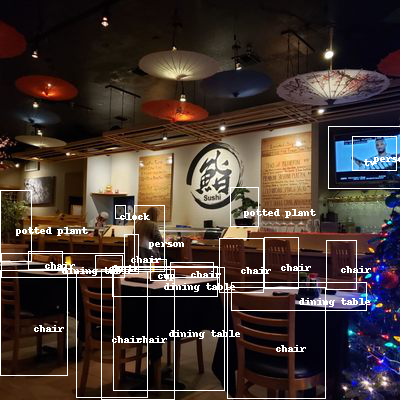

In [28]:
draw_boxes(od_model, filenames[1], 0.5)